In [19]:
import json
import os
import numpy as np
from keras.models import Model,load_model
from keras.layers import Input, LSTM, Dense,Activation,Embedding,merge,TimeDistributed
from keras.layers.core import Lambda
from keras.layers import concatenate,Reshape,Concatenate,RepeatVector,add
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.utils import plot_model
import numpy as np
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from nltk.translate.bleu_score import sentence_bleu
from keras.callbacks import EarlyStopping
import random
from PIL import Image
from matplotlib import pyplot as plt
import pickle
from keras import backend as K
import math
import random

In [3]:
coco_json='./data/dataset_coco.json'
tokenfile='./tokenv2.pkl'
detokenfile='./detokenv2.pkl'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
KTF.set_session(session)

In [4]:
with open(coco_json) as file:
    lines=file.readlines()
data=json.loads(lines[0])['images']

In [5]:
train_x_file=[]
train_y_seq=[]
vali_x_file=[]
vali_y_seq=[]
token={}
if os.path.exists(tokenfile):
    with open(tokenfile,'rb') as file:
        token=pickle.load(file)
else:
    token['\t']=1
    token['\n']=2

In [6]:
for d in data:
    if d['split']=='train':
        train_x_file.append('./coco/'+d['filepath']+'/'+d['filename'])
        len_of_sentences=len(d['sentences'])
        seq=d['sentences'][random.randint(0,len_of_sentences-1)]['tokens']
        for s in seq:
            if s not in token:
                token[s]=len(token)+1
        train_y_seq.append(['\t']+seq+['\n'])
    if d['split']=='test':
        vali_x_file.append('./coco/'+d['filepath']+'/'+d['filename'])
        seq=d['sentences'][0]['tokens']
        for s in seq:
            if s not in token:
                token[s]=len(token)+1
        vali_y_seq.append(['\t']+seq+['\n'])

In [7]:
with open(tokenfile,'wb') as file:
    pickle.dump(token,file)

if os.path.exists(detokenfile):
    with open(detokenfile,'rb') as file:
        detoken=pickle.load(file)
else:
    detoken=dict((i,char) for char,i in token.items())
    with open(detokenfile,'wb') as file:
        pickle.dump(detoken,file)

In [8]:
num_tokens=len(token)
batch_size=1
seq_len=49+2 #49+'\t'+'\n'
vec_len=4096
print("Num of train:",len(train_x_file))
print("Num of vali:",len(vali_x_file))
print("Num of token:",num_tokens)
print("Len of vector:",vec_len)
c = list(zip(train_x_file, train_y_seq))

random.shuffle(c)

train_x_file, train_y_seq = zip(*c)
train_x_file=train_x_file[:10000]
train_y_seq=train_y_seq[:10000]

Num of train: 82783
Num of vali: 5000
Num of token: 17631
Len of vector: 4096


In [9]:
vgg = VGG16(weights='imagenet')
vgg.layers.pop()
vggmodel=Model(inputs=vgg.inputs,outputs=vgg.layers[-1].output)

def vggextract(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #return vggmodel.predict(x)
    return np.reshape(vggmodel.predict(x),(4096))
a=vggextract('./file/000001.jpg')

In [10]:
dgenverbose=0
def dataGenerator(x,y):
    while(1):
        decoder_input_data=[]
        decoder_target_data=[]
        encoder_input_data=[]
        for index in range(len(x)):
            decoder_input_data=[]
            decoder_target_data=[]
            encoder_input_data=[]
            for t,word in enumerate(y[index]):
                if t>0:
                    did=np.zeros(
                        (seq_len),dtype='float32'
                    )
                    dtd=np.zeros(
                        (1),dtype='float32'
                    )
                    eid=vggextract(x[index])
                    encoder_input_data.append(eid)
                    if dgenverbose==1:
                        print("=============")
                        print("EID:",eid)
                        print("DID:")
                    for tt in range(t):
                        did[tt]=float(token[y[index][tt]])
                        if dgenverbose==1:
                            print(y[index][tt])
                    dtd[0]=float(token[y[index][t]])
                    if dgenverbose==1:
                        print("DTD:",y[index][t])
                        print("=============")
                    decoder_input_data.append(did)
                    decoder_target_data.append(dtd)
            yield ([np.array(encoder_input_data),np.array(decoder_input_data)],np.array(decoder_target_data))

In [23]:
latent_dim=128
encode_input=Input(shape=(vec_len,))
encode_dense=Dense(latent_dim,activation='relu')(encode_input)
#encode_dense=RepeatVector(1)(encode_dense) repeat only one time, for 1+51->52
encode_dense=RepeatVector(51)(encode_dense)
decode_input=Input(shape=(seq_len,))
decode_emb=Embedding(num_tokens+1,latent_dim,input_length=(seq_len))(decode_input)
#decoder_vec=concatenate([decode_emb,encode_dense],axis=1) for 1+51->52
decoder_LSTM=LSTM(latent_dim*2,return_sequences=True)(decode_emb)
decoder_timedistri=TimeDistributed(Dense(latent_dim))(decoder_LSTM)
decoder_vec=concatenate([decoder_timedistri,encode_dense])
decoder=LSTM(latent_dim*2)(decoder_vec)
decoder=Dense(num_tokens,activation='softmax')(decoder)
model=Model([encode_input,decode_input],decoder)

In [24]:
def ppx(y_true, y_pred):
     loss = K.sparse_categorical_crossentropy(y_true, y_pred)
     perplexity = K.cast(K.pow(math.e, K.mean(loss, axis=-1)), K.floatx())
     return perplexity

In [25]:
model.compile(loss=ppx, optimizer='adam',metrics=['accuracy'])

In [ ]:
cbes=EarlyStopping(patience=2,monitor='loss')
model.fit_generator(
    dataGenerator(train_x_file,train_y_seq),
    #validation_data=dataGenerator(vali_x_file,vali_y_seq),
    steps_per_epoch=((len(train_x_file))//batch_size),
    #steps_per_epoch=10000,
    #validation_steps=1,
    epochs=200,
    callbacks=[cbes]
)

Epoch 1/200
10000/10000 [==============================] - 1859s 186ms/step - loss: 526.0670 - acc: 0.0000e+00
Epoch 2/200
 9541/10000 [===========================>..] - ETA: 1:25 - loss: 493.3648 - acc: 0.0000e+00

In [ ]:
print("Train done")
model.save_weights('./vgg_model_weight.h5')
plot_model(model,to_file='./model_struct.jpg')

-
Input


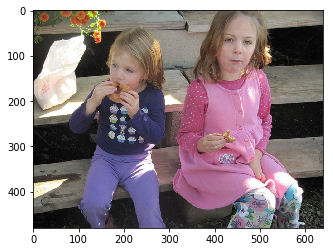

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'two', 'little', 'girls', 'sitting', 'on', 'the', 'steps', 'and', 'eating', 'some', 'food', '\n']
-
Input


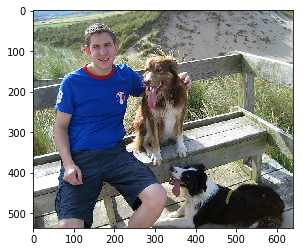

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'boy', 'sitting', 'on', 'a', 'bench', 'with', 'two', 'dogs', '\n']
-
Input


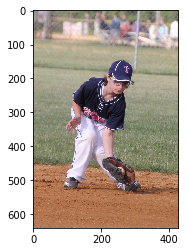

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'person', 'that', 'is', 'playing', 'in', 'a', 'baseball', 'game', '\n']
-
Input


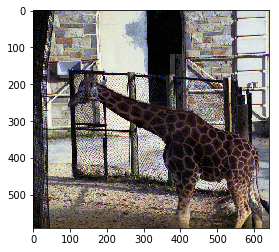

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'giraffe', 'in', 'an', 'enclosure', 'without', 'any', 'vegetation', 'visible', '\n']
-
Input


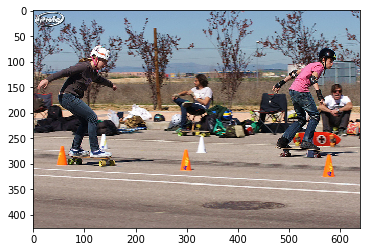

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'street', 'view', 'shows', 'several', 'watchers', 'sitting', 'curbside', 'with', 'piles', 'of', 'baggage', 'as', 'two', 'skateboarders', 'maneuver', 'past', 'cones', 'on', 'the', 'road', '\n']
-
Input


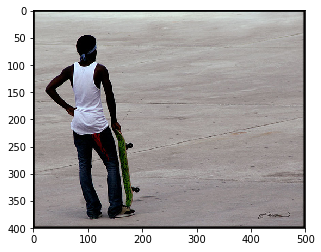

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'man', 'is', 'standing', 'and', 'holding', 'his', 'skateboard', 'next', 'to', 'him', '\n']
-
Input


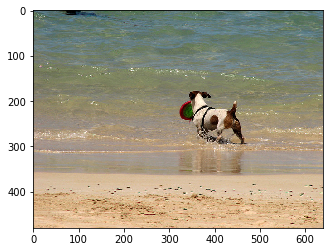

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'small', 'dog', 'headed', 'into', 'the', 'ocean', 'with', 'a', 'frisbee', 'in', 'its', 'mouth', '\n']
-
Input


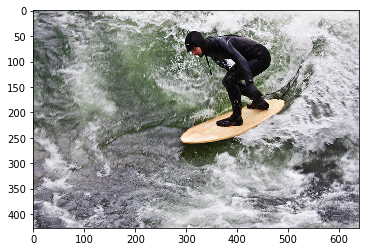

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'the', 'ocean', 'swirls', 'around', 'a', 'man', 'on', 'a', 'surfboard', '\n']
-
Input


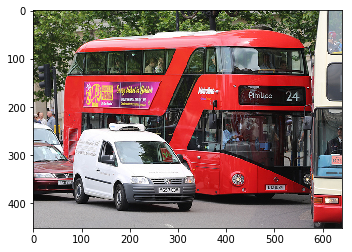

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'double', 'decker', 'bus', 'is', 'riding', 'along', 'a', 'busy', 'street', '\n']
-
Input


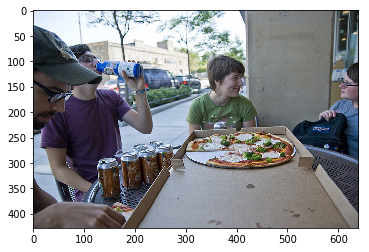

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'four', 'people', 'are', 'having', 'pizza', 'near', 'many', 'soda', 'cans', '\n']
-
Input


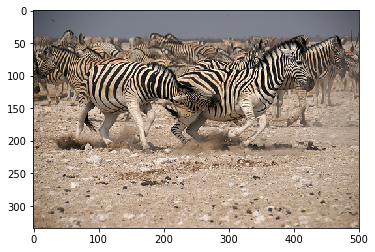

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'herd', 'of', 'zebras', 'running', 'over', 'rocky', 'terrain', '\n']
-
Input


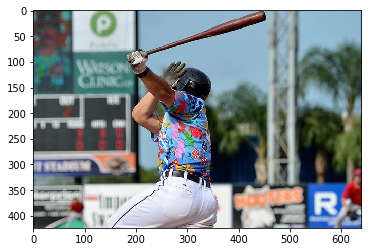

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'person', 'turns', 'sideways', 'and', 'holds', 'their', 'baseball', 'bat', 'out', '\n']
-
Input


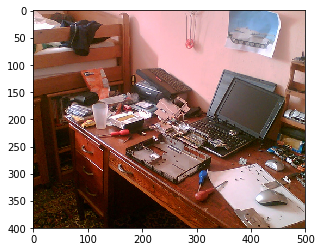

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'laptop', 'taken', 'apart', 'and', 'sitting', 'on', 'a', 'desk', 'next', 'to', 'some', 'tools', 'and', 'a', 'mouse', '\n']
-
Input


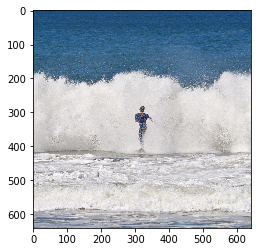

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'person', 'on', 'a', 'surfboard', 'riding', 'a', 'wave', '\n']
-
Input


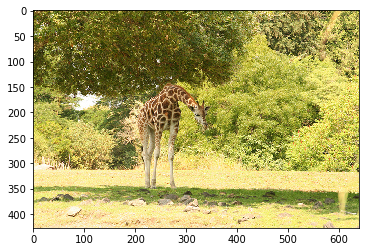

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'giraffe', 'standing', 'on', 'top', 'of', 'a', 'lush', 'green', 'field', 'near', 'a', 'forest', '\n']
-
Input


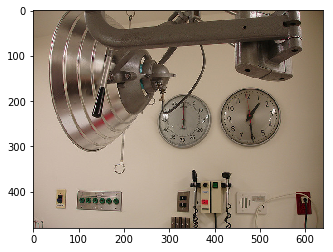

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'couple', 'of', 'clocks', 'mounted', 'to', 'the', 'side', 'of', 'a', 'wall', '\n']
-
Input


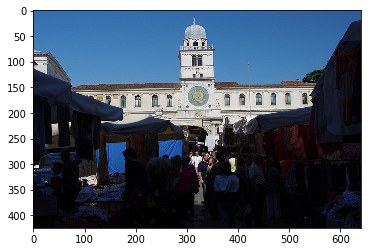

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'white', 'architectural', 'building', 'with', 'tiled', 'roof', 'and', 'cupola', '\n']
-
Input


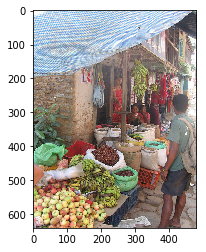

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'the', 'man', 'wearing', 'a', 'backpack', 'stands', 'close', 'to', 'an', 'outdoor', 'fruit', 'stand', '\n']
-
Input


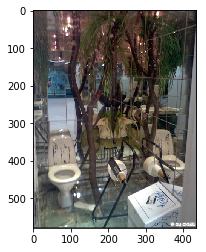

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'bathroom', 'decorated', 'with', 'mirrors', 'on', 'the', 'wall', '\n']
-
Input


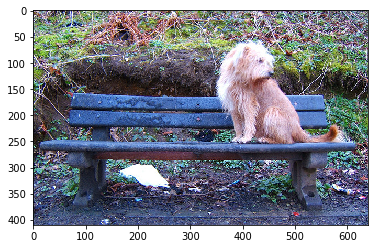

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'small', 'dog', 'perched', 'on', 'a', 'city', 'bench', '\n']
-
Input


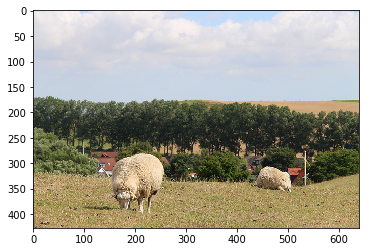

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'two', 'sheep', 'graze', 'in', 'a', 'meadow', 'above', 'a', 'village', '\n']
-
Input


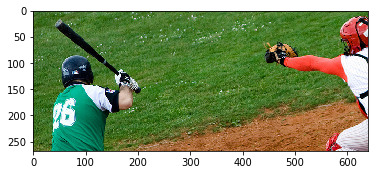

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'close', 'up', 'of', 'the', 'batter', 'about', 'to', 'smack', 'the', 'ball', '\n']
-
Input


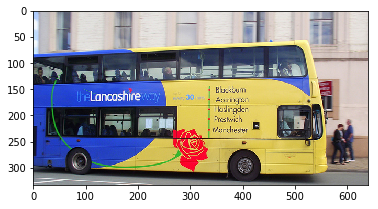

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'double', 'decker', 'bus', 'driving', 'down', 'a', 'street', '\n']
-
Input


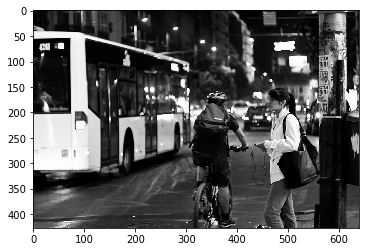

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'beautiful', 'woman', 'standing', 'next', 'to', 'a', 'street', 'as', 'a', 'man', 'rides', 'a', 'bike', 'past', 'her', '\n']
-
Input


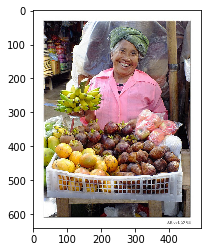

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'happy', 'woman', 'at', 'a', 'market', 'selling', 'fruit', '\n']
-
Input


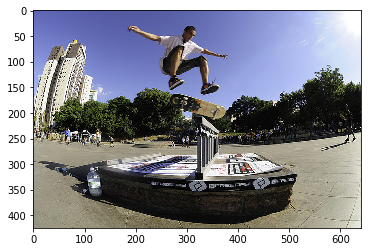

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'guy', 'on', 'skateboard', 'is', 'jumping', 'over', 'a', 'rail', '\n']
-
Input


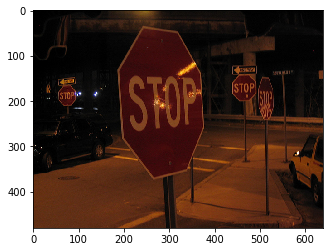

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'there', 'are', 'many', 'stop', 'and', 'one', 'way', 'signs', '\n']
-
Input


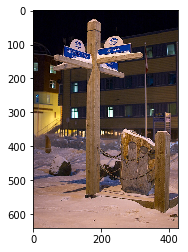

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'four', 'white', 'and', 'blue', 'street', 'signs', 'on', 'a', 'wooden', 'pole', '\n']
-
Input


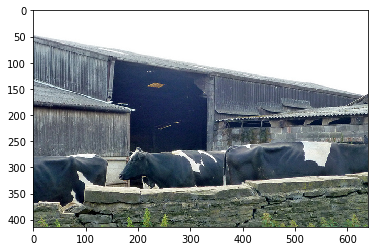

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'group', 'of', 'cattle', 'sitting', 'in', 'a', 'pen', 'next', 'to', 'a', 'barn', '\n']
-
Input


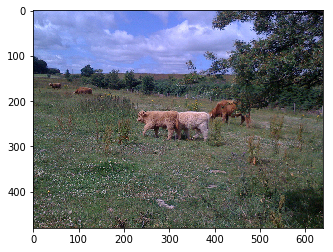

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'couple', 'of', 'animals', 'that', 'are', 'in', 'the', 'grass', '\n']
-
Input


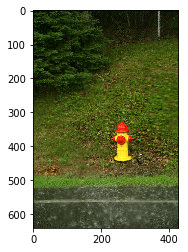

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'bright', 'yellow', 'and', 'red', 'fire', 'hydrant', 'in', 'green', 'yard', '\n']
-
Input


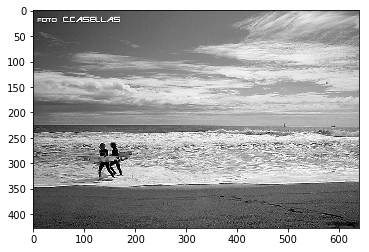

Decoded sentence:  a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
should be: ['\t', 'a', 'black', 'and', 'white', 'scene', 'of', 'two', 'children', 'carrying', 'a', 'surfboard', 'on', 'the', 'beach', '\n']


In [17]:
def decode(code,seq,seq_index,sentence):
    print("Input seq:",seq)
    decode_token_index=np.argmax(model.predict([code,seq])[0])
    seq[0][seq_index]=decode_token_index
    if decode_token_index==0:
        sampled_char=' '
        print("Sampled:",decode_token_index," ")
    else:
        sampled_char=detoken[decode_token_index]
        print("Sampled:",decode_token_index,sampled_char)
    sentence+=(" "+sampled_char)
    if seq_index+1==seq_len or sampled_char=='\n':
        return sentence
    else:
        return decode(code,seq,seq_index+1,sentence)
    
indices=random.sample(range(len(train_x_file)),32)
for index in indices:
    code=vggextract(train_x_file[index])
    code=np.reshape(code,(1,code.shape[0]))
    did=np.zeros(
        (seq_len),dtype='float32'
    )
    did=np.reshape(did,(1,did.shape[0]))
    did[0][0]=float(token['\t'])
    sentence=decode(code,did,1,"")
    print("-")
    print("Input")
    plt.imshow(np.asarray(Image.open(train_x_file[index])))
    plt.show()
    print("Decoded sentence:",sentence)
    print("should be:",train_y_seq[index])